# Demographic Analysis

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Plotly template config
pio.templates.default = "plotly_white"

### Loading datasets

In [3]:
df_enrolment = pd.read_parquet('enrolment_cleaned.parquet')
df_demographic = pd.read_parquet('demographic_cleaned.parquet')
df_biometric = pd.read_parquet('biometric_cleaned.parquet')

### Adult Update Frequency Patterns
##### To see how adults interact with the system

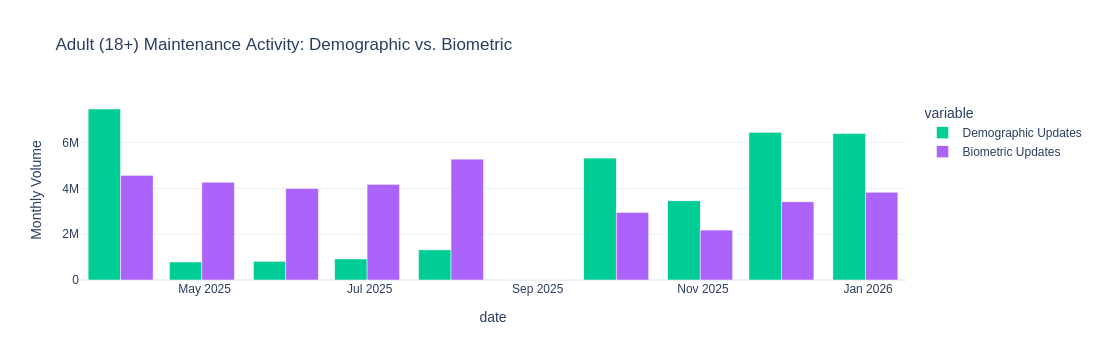

In [8]:
def analyze_adult_updates(df_demo, df_bio):
    # 1. Focus on 18+ Columns
    demo_col = [c for c in df_demo.columns if '17_' in c][0]
    bio_col = [c for c in df_bio.columns if '17_' in c][0]
    
    # 2. Aggregate by Month
    m_demo = df_demo.set_index('date')[[demo_col]].resample('ME').sum().rename(columns={demo_col: 'Demographic Updates'})
    m_bio = df_bio.set_index('date')[[bio_col]].resample('ME').sum().rename(columns={bio_col: 'Biometric Updates'})
    
    # 3. Merge
    combined = pd.concat([m_demo, m_bio], axis=1)
    
    # 4. Plot Comparison
    fig = px.bar(
        combined,
        barmode='group',
        title="Adult (18+) Maintenance Activity: Demographic vs. Biometric",
        labels={'value': 'Monthly Volume', 'index': 'Date'},
        color_discrete_sequence=['#00CC96', '#AB63FA'] # Green (Demo), Purple (Bio)
    )
    fig.show()

analyze_adult_updates(df_demographic, df_biometric)

### Age Group Migration
##### To use "Demographic Updates" (Address Changes) as a proxy for migration.

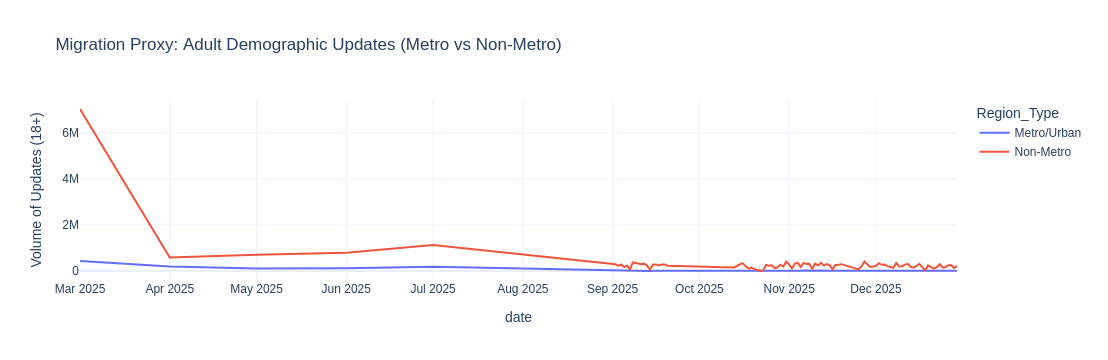

In [10]:
def analyze_migration_proxy(df_demo):
    # 1. Tag Districts as Urban/Rural (using Tier logic from previous step)
    tier_1_cities = ['Ahmedabad', 'Bengaluru', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai', 'Pune']
    
    def get_tier(d):
        return 'Metro/Urban' if any(x.lower() in str(d).lower() for x in tier_1_cities) else 'Non-Metro'
    
    df_demo['Region_Type'] = df_demo['district'].apply(get_tier)
    
    # 2. Focus on 18+ Demographic Updates (Address changes are most common here)
    target_col = [c for c in df_demo.columns if '17_' in c][0]
    
    # 3. Aggregate trends by Region Type
    trend = df_demo.groupby(['date', 'Region_Type'])[target_col].sum().reset_index()
    
    # 4. Plot Trend
    fig = px.line(
        trend, 
        x='date', 
        y=target_col, 
        color='Region_Type',
        title="Migration Proxy: Adult Demographic Updates (Metro vs Non-Metro)",
        labels={target_col: 'Volume of Updates (18+)'}
    )
    fig.show()

analyze_migration_proxy(df_demographic)

### Biometric Update Compliance Rates by Age
##### To see which age group (5-17 vs 18+) is driving the biometric volume

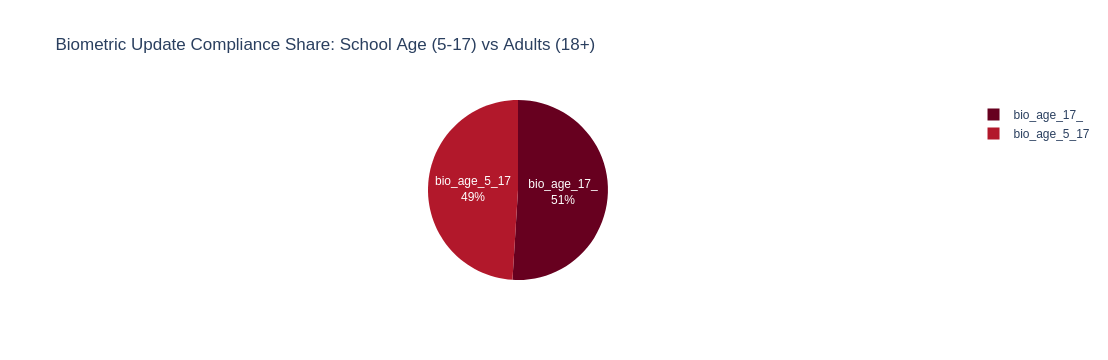

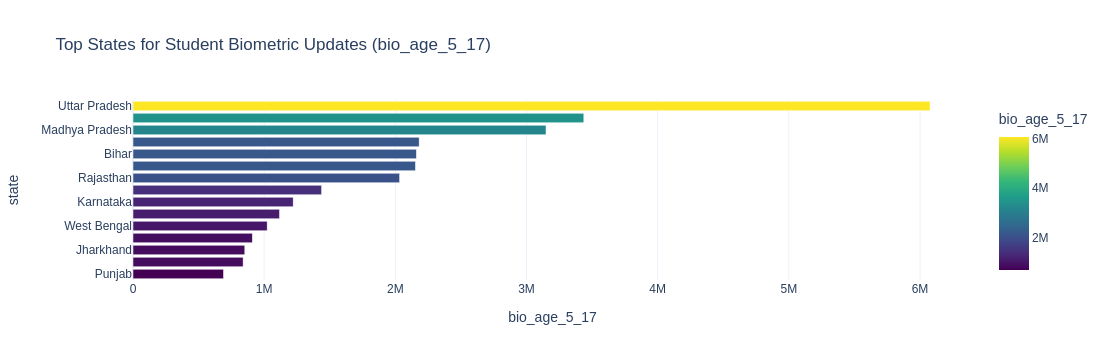

In [12]:
def analyze_biometric_compliance(df_bio):
    # 1. Identify Groups
    cols = [c for c in df_bio.columns if 'age' in c.lower()]
    
    # 2. Sum Totals
    total_counts = df_bio[cols].sum().reset_index()
    total_counts.columns = ['Age_Group', 'Total_Volume']
    
    # 3. Pie Chart for Share
    fig = px.pie(
        total_counts, 
        values='Total_Volume', 
        names='Age_Group',
        title="Biometric Update Compliance Share: School Age (5-17) vs Adults (18+)",
        color_discrete_sequence=px.colors.sequential.RdBu
    )
    fig.update_traces(textinfo='percent+label')
    fig.show()
    
    # 4. State-wise Compliance Map (Where are the 5-17 updates happening?)
    # We want to find states doing a good job enforcing the "Mandatory Child Update"
    
    # Filter for 5-17 column
    child_col = [c for c in cols if '5' in c and '17' in c][0]
    
    state_compliance = df_bio.groupby('state')[child_col].sum().reset_index()
    
    # Plot Map (Simple Bar if map fails, or reuse map function)
    fig2 = px.bar(
        state_compliance.sort_values(child_col, ascending=False).head(15),
        x=child_col,
        y='state',
        orientation='h',
        title=f"Top States for Student Biometric Updates ({child_col})",
        color=child_col,
        color_continuous_scale='Viridis'
    )
    fig2.update_layout(yaxis={'categoryorder':'total ascending'})
    fig2.show()

analyze_biometric_compliance(df_biometric)